# SQL Employee Attrition

### Step 1: Import Libraries

In [1]:
import pandas as pd
import sqlite3
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Extract and Load Data

In [2]:
# Extract the ZIP file
zip_file_path = 'Employee Attrition for Healthcare.zip'
extracted_folder = 'extracted_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)
    print(f"Extracted files: {zip_ref.namelist()}")

# Verify extracted files
files = os.listdir(extracted_folder)
print(f"Files in extracted folder: {files}")

# Load data into Pandas DataFrames
attrition_file = os.path.join(extracted_folder, 'watson_healthcare_modified.csv')
shap_file = os.path.join(extracted_folder, 'watson_shap_values_for_testset.csv')

df_attrition = pd.read_csv(attrition_file)
df_shap = pd.read_csv(shap_file)

# Display data previews
print("\nPreview of Attrition Dataset:")
print(df_attrition.head())

print("\nPreview of SHAP Values Dataset:")
print(df_shap.head())

# Load data into SQLite
db_path = 'employee_attrition.db'
conn = sqlite3.connect(db_path)

# Save DataFrames to SQLite
df_attrition.to_sql('attrition', conn, if_exists='replace', index=False)
df_shap.to_sql('shap_values', conn, if_exists='replace', index=False)

print("\nData loaded into SQLite database.")


Extracted files: ['NSI_National_Health_Care_Retention_Report.pdf', 'watson_healthcare_modified.csv', 'watson_shap_values_for_testset.csv']
Files in extracted folder: ['ENB2012_data.xlsx', 'NSI_National_Health_Care_Retention_Report.pdf', 'test_dataset.csv', 'train_dataset.csv', 'watson_healthcare_modified.csv', 'watson_shap_values_for_testset.csv']

Preview of Attrition Dataset:
   EmployeeID  Age Attrition     BusinessTravel  DailyRate  Department  \
0     1313919   41        No      Travel_Rarely       1102  Cardiology   
1     1200302   49        No  Travel_Frequently        279   Maternity   
2     1060315   37       Yes      Travel_Rarely       1373   Maternity   
3     1272912   33        No  Travel_Frequently       1392   Maternity   
4     1414939   27        No      Travel_Rarely        591   Maternity   

   DistanceFromHome  Education EducationField  EmployeeCount  ...  \
0                 1          2  Life Sciences              1  ...   
1                 8          1  Life

### Step 3: Explore the Database

In [3]:
# List all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print("\nTables in the Database:")
print(tables)

# Check the schema of the 'attrition' table
query = "PRAGMA table_info(attrition);"
schema_attrition = pd.read_sql_query(query, conn)
print("\nSchema for 'attrition' Table:")
print(schema_attrition)

# Check the schema of the 'shap_values' table
query = "PRAGMA table_info(shap_values);"
schema_shap = pd.read_sql_query(query, conn)
print("\nSchema for 'shap_values' Table:")
print(schema_shap)

# Preview the 'attrition' table
query = "SELECT * FROM attrition LIMIT 5;"
attrition_sample = pd.read_sql_query(query, conn)
print("\nSample Data from 'attrition' Table:")
print(attrition_sample)


Tables in the Database:
          name
0    attrition
1  shap_values

Schema for 'attrition' Table:
    cid                      name     type  notnull dflt_value  pk
0     0                EmployeeID  INTEGER        0       None   0
1     1                       Age  INTEGER        0       None   0
2     2                 Attrition     TEXT        0       None   0
3     3            BusinessTravel     TEXT        0       None   0
4     4                 DailyRate  INTEGER        0       None   0
5     5                Department     TEXT        0       None   0
6     6          DistanceFromHome  INTEGER        0       None   0
7     7                 Education  INTEGER        0       None   0
8     8            EducationField     TEXT        0       None   0
9     9             EmployeeCount  INTEGER        0       None   0
10   10   EnvironmentSatisfaction  INTEGER        0       None   0
11   11                    Gender     TEXT        0       None   0
12   12                Hourl

### Step 4: SQL Analysis Queries

In [5]:
query = """
SELECT Department, 
       COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) AS AttritionCount,
       COUNT(*) AS TotalEmployees,
       (COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) * 100.0) / COUNT(*) AS AttritionRate
FROM attrition
GROUP BY Department
ORDER BY AttritionRate DESC;
"""
department_attrition = pd.read_sql_query(query, conn)
print("\nAttrition Rate by Department:")
print(department_attrition)


Attrition Rate by Department:
   Department  AttritionCount  TotalEmployees  AttritionRate
0  Cardiology              74             531      13.935970
1   Maternity              98             796      12.311558
2   Neurology              27             349       7.736390


In [6]:
query = """
SELECT Gender, 
       CASE 
           WHEN Age < 30 THEN 'Under 30'
           WHEN Age BETWEEN 30 AND 50 THEN '30-50'
           ELSE 'Over 50'
       END AS AgeGroup,
       COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) AS AttritionCount,
       COUNT(*) AS TotalEmployees,
       (COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) * 100.0) / COUNT(*) AS AttritionRate
FROM attrition
GROUP BY Gender, AgeGroup
ORDER BY AttritionRate DESC;
"""
gender_age_attrition = pd.read_sql_query(query, conn)
print("\nAttrition by Gender and Age Group:")
print(gender_age_attrition)



Attrition by Gender and Age Group:
   Gender  AgeGroup  AttritionCount  TotalEmployees  AttritionRate
0  Female  Under 30              47             140      33.571429
1    Male  Under 30              54             245      22.040816
2    Male   Over 50               8              90       8.888889
3  Female     30-50              37             466       7.939914
4    Male     30-50              51             663       7.692308
5  Female   Over 50               2              72       2.777778


In [7]:
query = """
SELECT JobSatisfaction, 
       COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) AS AttritionCount,
       COUNT(*) AS TotalEmployees,
       (COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) * 100.0) / COUNT(*) AS AttritionRate
FROM attrition
GROUP BY JobSatisfaction
ORDER BY JobSatisfaction;
"""
job_satisfaction_attrition = pd.read_sql_query(query, conn)
print("\nAttrition Based on Job Satisfaction:")
print(job_satisfaction_attrition)



Attrition Based on Job Satisfaction:
   JobSatisfaction  AttritionCount  TotalEmployees  AttritionRate
0                1              52             329      15.805471
1                2              42             310      13.548387
2                3              60             507      11.834320
3                4              45             530       8.490566


In [8]:
query = """
SELECT BusinessTravel, 
       COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) AS AttritionCount,
       COUNT(*) AS TotalEmployees,
       (COUNT(CASE WHEN Attrition = 'Yes' THEN 1 END) * 100.0) / COUNT(*) AS AttritionRate
FROM attrition
GROUP BY BusinessTravel
ORDER BY AttritionRate DESC;
"""
business_travel_attrition = pd.read_sql_query(query, conn)
print("\nAttrition by Business Travel Frequency:")
print(business_travel_attrition)



Attrition by Business Travel Frequency:
      BusinessTravel  AttritionCount  TotalEmployees  AttritionRate
0  Travel_Frequently              57             320      17.812500
1      Travel_Rarely             126            1184      10.641892
2         Non-Travel              16             172       9.302326


In [14]:
# Query for SHAP summary
query = """
SELECT 
    AVG(Age) AS AvgAgeSHAP,
    AVG(DailyRate) AS AvgDailyRateSHAP,
    AVG(EnvironmentSatisfaction) AS AvgEnvSatisfactionSHAP,
    AVG(MonthlyIncome) AS AvgMonthlyIncomeSHAP,
    AVG(YearsAtCompany) AS AvgYearsAtCompanySHAP
FROM shap_values;
"""

### Step 5: Save results to CSV files

In [13]:
try:
    shap_summary = pd.read_sql_query(query, conn)
    print("\nSHAP Summary for Selected Features:")
    print(shap_summary)
except Exception as e:
    print(f"Error occurred while querying SHAP summary: {e}")

# Save results to CSV files with error handling
try:
    if 'department_attrition' in locals():
        department_attrition.to_csv('department_attrition.csv', index=False)
    else:
        print("Warning: 'department_attrition' DataFrame is not defined.")

    if 'gender_age_attrition' in locals():
        gender_age_attrition.to_csv('gender_age_attrition.csv', index=False)
    else:
        print("Warning: 'gender_age_attrition' DataFrame is not defined.")

    if 'job_satisfaction_attrition' in locals():
        job_satisfaction_attrition.to_csv('job_satisfaction_attrition.csv', index=False)
    else:
        print("Warning: 'job_satisfaction_attrition' DataFrame is not defined.")

    if 'business_travel_attrition' in locals():
        business_travel_attrition.to_csv('business_travel_attrition.csv', index=False)
    else:
        print("Warning: 'business_travel_attrition' DataFrame is not defined.")

    if 'shap_summary' in locals() and not shap_summary.empty:
        shap_summary.to_csv('shap_summary.csv', index=False)
        print("SHAP Summary saved to 'shap_summary.csv'")
    else:
        print("Warning: 'shap_summary' DataFrame is empty or not defined.")

    print("\nKey results saved to CSV files.")
except Exception as e:
    print(f"An unexpected error occurred while saving files: {e}")


SHAP Summary for Selected Features:
   AvgAgeSHAP  AvgDailyRateSHAP  AvgEnvSatisfactionSHAP  AvgMonthlyIncomeSHAP  \
0   -0.011018         -0.005466               -0.008946             -0.028045   

   AvgYearsAtCompanySHAP  
0              -0.011789  
SHAP Summary saved to 'shap_summary.csv'

Key results saved to CSV files.


### Step 6: Visualization

C:\Users\milto\AppData\Local\Temp\ipykernel_20876\2503852956.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=department_attrition, x='AttritionRate', y='Department', palette='viridis')


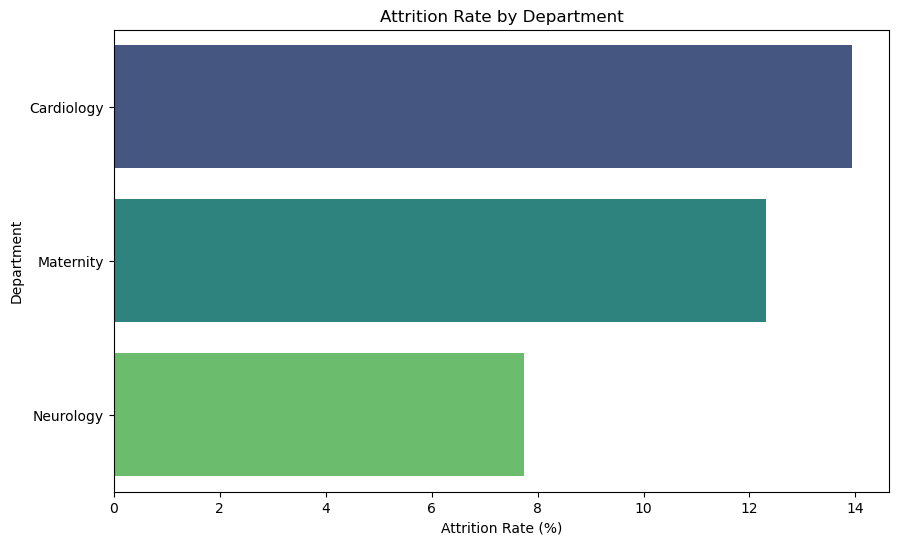

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(data=department_attrition, x='AttritionRate', y='Department', palette='viridis')
plt.title('Attrition Rate by Department')
plt.xlabel('Attrition Rate (%)')
plt.ylabel('Department')
plt.show()